# Lab - Assignment1
Aadarsh Siddha
Praneith Ranganath

In [165]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [166]:
# A class to prep data before fitting model
class DataPrep:
    
    def __init__(self, X, target, test_split_ratio):
        self.X = X
        self.target = target
        self.test_split_ratio = test_split_ratio
    
    # split data based on a target var
    def data_split(self, X, target, test_split_ratio):
        X_data = X.drop([target], axis=1)
        y_data = X[target]
        self.trainX, self.testX, self.trainY, self.testY = train_test_split(X_data, 
                                                                            y_data,test_size = test_split_ratio)
        return self.trainX, self.testX, self.trainY, self.testY
    
    # add coloumn X0=1
    def add_X0(self, X):
        return np.column_stack([np.ones(X.shape[0]), X])
    
    def normalize_testdata(self, X):
        mean = np.mean(X, axis=0)
        std = np.std(X, axis=0)
        X = (X-mean) / std
        X = self.add_X0(X)
        return X, mean, std
    
    def normalize_traindata(self, X, mean, std):
        X = (X-mean) / std
        X = self.add_X0(X)
        return X
    
    def fit(self):
        trainX, testX, trainY, testY = self.data_split(self.X, self.target, self.test_split_ratio)
        normalized_trainX, mean, std = self.normalize_testdata(trainX)
        normalized_testX = self.normalize_traindata(testX, mean, std)
        return normalized_trainX, normalized_testX, trainY, testY, mean, std
        
        
        
    
        

In [167]:
class LinearRegression:
    
    def __init__(self, X, y, learning_rate, regularization_constant, 
                 solution_type='gd', regularization= False, max_iteration = 10000, tolerance=1e-8) -> None: 
        self.X = X
        self.y = y
        self.max_iteration = max_iteration
        self.tolerance = tolerance
        self.learning_rate = learning_rate
        self.solution_type = solution_type
        self.regularization = regularization
        self.regularization_constant = regularization_constant
    
    # used to plot a line graph
    def plot_rmse(self, error_sequence):
        plt.figure(figsize=(12, 8), edgecolor = 'black', facecolor='white', layout='tight')
        plt.title("Error over Iteration's")
        plt.xlabel("Iteration")
        plt.ylabel("Error")
        sns.lineplot(x=np.arange((np.array(error_sequence)).size), y = error_sequence)
        plt.show()
        
    
    #rank of a matrix
    def rank(self, X):
        left, sigma, right = np.linalg.svd(X)
        return np.sum(sigma > 0.000001)
    
    def low_rank(self, X):
        if(X.shape[0]<X.shape[1]):
            return True
        else:
            return False
    
    def full_rank(self, X):
        if min(X.shape) == self.rank(X):
            return True
        else:
            return False
    
    #closed form solution for linear regression
    def closed_room_solution_without_reg(self, X, y):
        if self.full_rank(X) and not self.low_rank(X):
            self.weights = np.matmul(np.linalg.inv(np.matmul(self.X.T,self.X)), np.matmul(self.X.T, self.y))
            print(self.weights)
        else:
            print('Closed form solution not possible as it is not full rank')
                                     
    def closed_room_solution_with_reg(self, X, y, regularization_constant):
        if self.full_rank(X) and not self.low_rank(X):
            self.weights = np.matmul(np.linalg.inv(np.matmul(self.X.T,self.X) 
                                                   + self.regularization_constant * np.identity(self.X.shape[1])),
                                     np.matmul(self.X.T, self.y))
            print(self.weights)
        else:
            print('Closed form solution not possible as it is not full rank')
    
    def predict(self, X):
        return X.dot(self.weights)   
    
    def sse(self, X, y):  
        return ((self.predict(X) - y)**2).sum()
    
    def rmse(self, X, y):  
        return np.sqrt(self.sse(X, y)/X.shape[0])
    
    def cost_function(self, X , y):
        loss = self.sse(X, y)
        return loss/2
    
    def cost_function_derivative(self, X, y):
        y_hat = self.predict(X)
        return np.matmul(X.T, (y_hat - y))
    
    #gradient decent for linear regression
    def gradient_descent(self, X, y):
        prev_error = float('inf')
        error_loss = []
        for iter in tqdm(range(1, self.max_iteration)):
            self.weights -= self.learning_rate * self.cost_function_derivative(X, y)
            loss = self.rmse(X, y)
            error_loss.append(loss)
            if abs(loss - prev_error) < self.tolerance:
                print("Model stopped learning")
                break
            prev_error = loss
        print(self.weights)
        self.plot_rmse(error_loss)
        
        
    def gradient_descent_with_reg(self, X, y):
        prev_error = float('inf')
        error_loss = []
        for iter in tqdm(range(1, self.max_iteration)):
            self.weights -= self.learning_rate * (self.cost_function_derivative(X, y) + self.regularization_constant * self.weights)
            loss = self.rmse(X, y)
            error_loss.append(loss)
            if abs(loss - prev_error) < self.tolerance:
                print("Model stopped learning")
                break
            prev_error = loss
        print(self.weights)
        self.plot_rmse(error_loss)
           
    def evaluation_metrics(self, mode, X=None, y=None):
        if mode == "train":
            print("Training metrics")
            y_hat = self.predict(self.X)
            print("RMSE(training) -->", ((((y_hat - self.y) ** 2).sum())/len(self.y))** 0.5)
            print("SSE(training) -->", ((y_hat - self.y) ** 2).sum())
            print("\n")
        elif (mode == 'test') and (X is not None) and (y is not None):
            print("Test metrics")
            y_hat = self.predict(X)
            print("RMSE(test) -->", ((((y_hat - y) ** 2).sum())/len(y))** 0.5)
            print("SSE(test) -->", ((y_hat - y) ** 2).sum())    
            print("\n")
            
    def fit(self):
        if(self.solution_type == 'closed'):
            if(self.regularization):
                self.closed_room_solution_with_reg(self.X, self.y, self.regularization_constant)
            else:
                self.closed_room_solution_without_reg(self.X, self.y)
        elif(self.solution_type == 'gd' or self.solution_type == 'sgd'):
            self.weights = np.ones(self.X.shape[1])
            if(self.regularization):
                if (self.solution_type == 'sgd'):
                    X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, train_size=0.1)
                    self.gradient_descent_with_reg(X_train, y_train)
                else:
                    self.gradient_descent_with_reg(self.X, self.y)
            else:
                if (self.solution_type == 'sgd'):
                    X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, train_size=0.1)
                    self.gradient_descent(X_train, y_train)
                else:
                    self.gradient_descent(self.X, self.y)
        
            
            
   

# Housing Dataset


In [204]:
house = pd.read_csv("/Users/praneithranganath/Downloads/housing.csv")
house.head()

,0.00632,18,2.31,0,0.538,6.575,65.2,4.09,1,296,15.3,396.9,4.98,24
0,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
1,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
2,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
3,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
4,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21,28.7


In [205]:
d1 = DataPrep(house, '24', 0.25)

In [206]:
train_X, test_X, train_Y, test_Y, mean, std = d1.fit()

Closed form 

In [213]:
l1 = LinearRegression(train_X, train_Y, 0.1 * 1e-2, 0.2, "closed", regularization=True)
l1.fit()

[22.57852988 -0.72268729  0.87398689 -0.14639509  0.69459073 -1.08870653
  3.58452575 -0.68438797 -2.59059746  1.9607501  -1.86673574 -1.91268172
  0.83123091 -2.72786557]


In [214]:
l1.evaluation_metrics(mode ='train')

Training metrics
RMSE(training) --> 4.159631887389976
SSE(training) --> 6540.359151787585




In [215]:
l1.evaluation_metrics(mode ='test', X=test_X, y=test_Y)

Test metrics
RMSE(test) --> 6.220060128100889
SSE(test) --> 4913.521795643188




Gradient Descent

  0%|                                       | 31/9999 [00:00<00:05, 1961.37it/s]

Model stopped learning
[22.47612722 -0.42852285  0.45007865 -0.32194136  0.76710194 -0.36050268
  4.01209009 -0.47047431 -1.44914164  0.64871527 -0.78973085 -1.77145294
  0.88518499 -2.59888115]


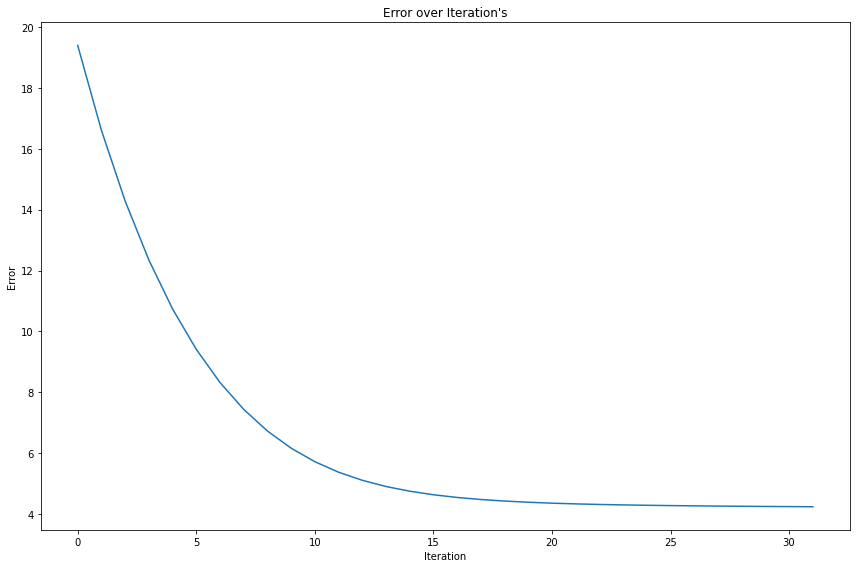

In [216]:
l2 = LinearRegression(train_X, train_Y, 0.4 * 1e-3, 0.01, "gd", regularization = True, tolerance = 0.5 * 1e-2)
l2.fit()

In [217]:
l2.evaluation_metrics(mode ='train')

Training metrics
RMSE(training) --> 4.238205811494615
SSE(training) --> 6789.7828532217845




In [218]:
l2.evaluation_metrics(mode ='test', X=test_X, y=test_Y)

Test metrics
RMSE(test) --> 6.5144637404969
SSE(test) --> 5389.656203933606




Decreasing the learning rate from above we can observe that the jump size between each iteration is reduced thus increasing the number of iterations.

 10%|███▉                                 | 1049/9999 [00:00<00:01, 5502.09it/s]


Model stopped learning
[18.18205468 -0.34264222  0.76287028 -0.21572825  0.98573132  0.06063249
  3.93538663  0.0369481  -0.1106615   0.10834608 -0.58352739 -1.35261788
  1.18285885 -1.95130076]


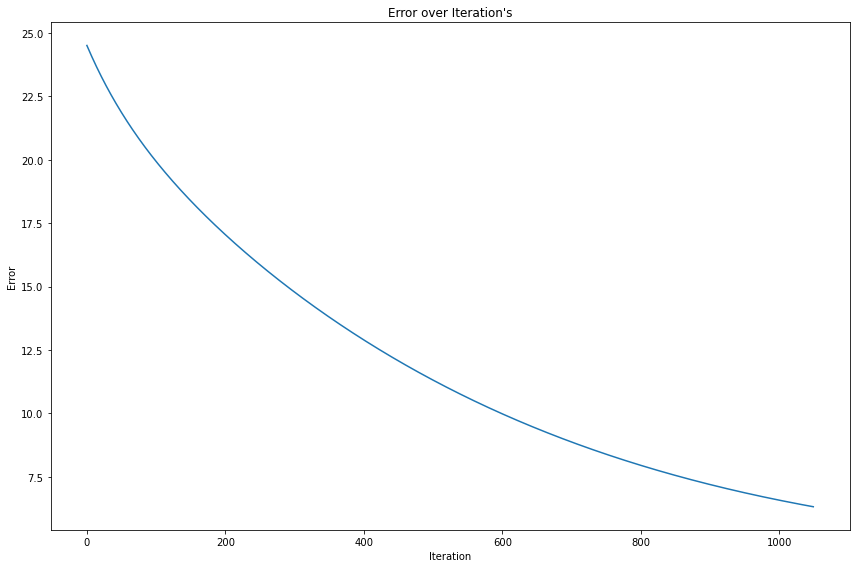

In [219]:
l22 = LinearRegression(train_X, train_Y, 0.004 * 1e-3, 0.01, "gd", regularization = True, tolerance = 0.5 * 1e-2)
l22.fit()

Stochastic GD

  2%|▉                                     | 243/9999 [00:00<00:02, 3842.62it/s]

Model stopped learning
[20.44305535 -1.24619283 -1.38435879 -0.81921545  0.03480066  0.51454294
  3.36039364 -0.68793208  0.30301777 -0.90908717  0.41037851 -0.69006831
  1.46794373 -2.15164736]


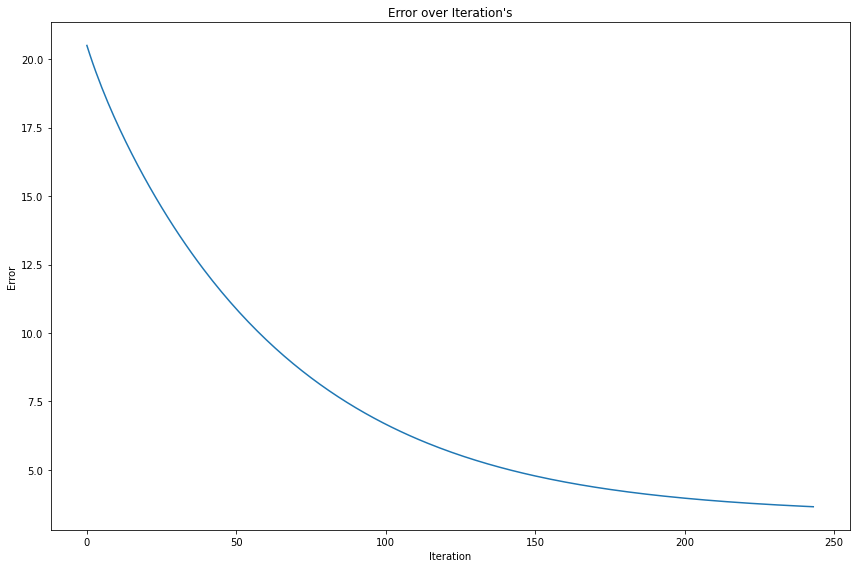

In [178]:
l3 = LinearRegression(train_X, train_Y, 0.4 * 1e-3, 0.01, "sgd", regularization = True, tolerance = 0.5 * 1e-2)
l3.fit()

In [179]:
l3.evaluation_metrics(mode ='train')

Training metrics
RMSE(training) --> 6.181452614614401
SSE(training) --> 14443.514729301376




In [180]:
l3.evaluation_metrics(mode ='test', X=test_X, y=test_Y)

Test metrics
RMSE(test) --> 5.622040636547339
SSE(test) --> 4014.1322967116807




  1%|▎                                      | 70/9999 [00:00<00:04, 2410.46it/s]

Model stopped learning
[ 5.80050882 -0.26251971  0.34580396 -0.4274781   0.48429017 -0.83759437
  0.76405425 -0.24004573  0.63067222 -0.0085986  -0.48361745  0.2394745
  0.32245115 -0.41654342]


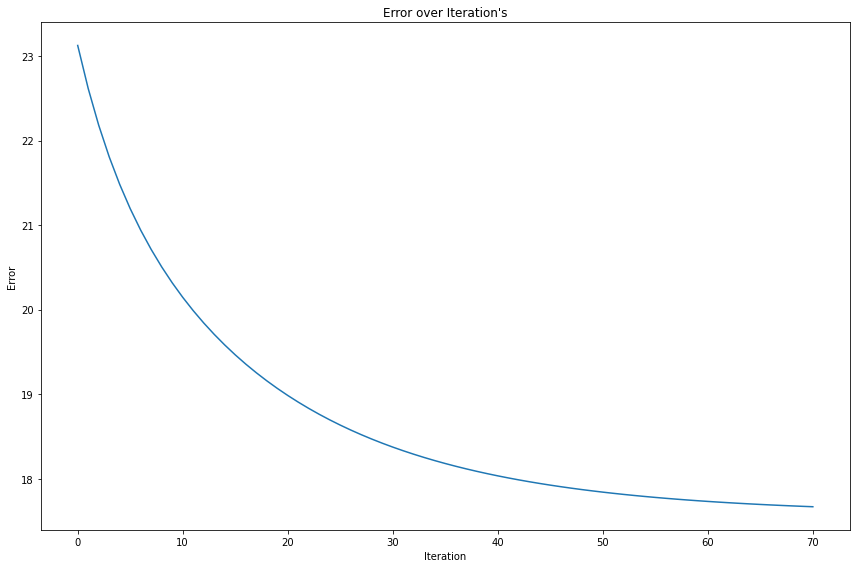

In [181]:
l33 = LinearRegression(train_X, train_Y, 0.4 * 1e-3, 100, "sgd", regularization = True, tolerance = 0.5 * 1e-2)
l33.fit()

From l3 and l33 it is evident that increase in regularization parametere penalizes increase in weights therby reducing the weights as shown above.

# Yacht Dataset


In [182]:
yacht = pd.read_csv("/Users/praneithranganath/Downloads/yachtData.csv")
yacht.head()

,-2.3,0.568,4.78,3.99,3.17,0.125,0.11
0,-2.3,0.568,4.78,3.99,3.17,0.150,0.27
1,-2.3,0.568,4.78,3.99,3.17,0.175,0.47
2,-2.3,0.568,4.78,3.99,3.17,0.200,0.78
3,-2.3,0.568,4.78,3.99,3.17,0.225,1.18
4,-2.3,0.568,4.78,3.99,3.17,0.250,1.82


In [183]:
d2 = DataPrep(yacht, '0.11', 0.25)

In [184]:
train_X, test_X, train_Y, test_Y, mean, std = d2.fit()

Closed form

In [185]:
l7 = LinearRegression(train_X, train_Y, 0.1 * 1e-2, 0.01, "closed")
l7.fit()

[10.39165217  0.2496269   0.03394441  3.64779285 -2.15942029 -3.43111857
 12.04633782]


In [186]:
l7.evaluation_metrics(mode ='train')

Training metrics
RMSE(training) --> 8.569856202150026
SSE(training) --> 16891.76012487173




In [187]:
l7.evaluation_metrics(mode ='test', X=test_X, y=test_Y)

Test metrics
RMSE(test) --> 9.806213845376552
SSE(test) --> 7404.460908556618




Gradient Descent

  2%|▋                                     | 189/9999 [00:00<00:02, 3911.01it/s]

Model stopped learning
[10.27832383  0.22455785 -0.78290108  0.19866444  0.45198527 -0.07095365
 11.88558927]


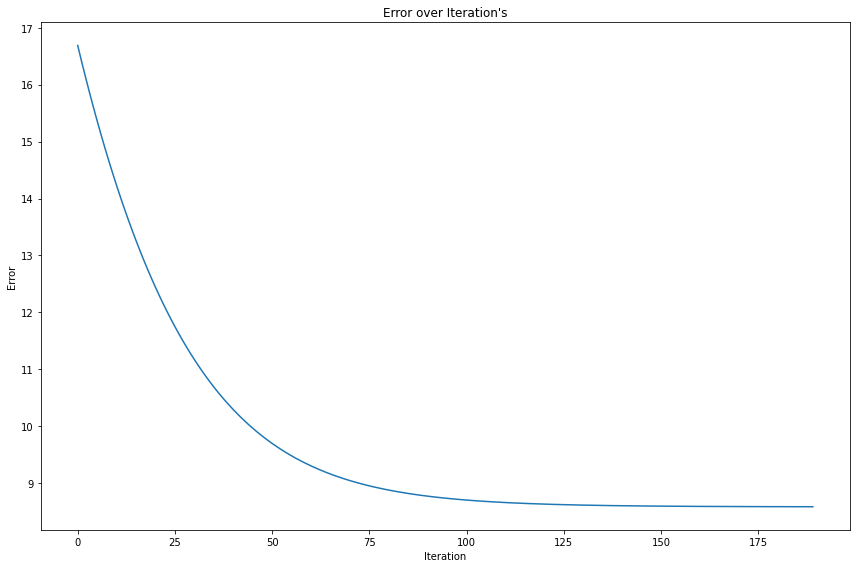

In [188]:
l4 = LinearRegression(train_X, train_Y, 0.01 * 1e-2, 0.01, "gd", regularization = True, tolerance = 0.01 * 1e-2)
l4.fit()

In [189]:
l4.evaluation_metrics(mode ='train')

Training metrics
RMSE(training) --> 8.583421607715815
SSE(training) --> 16945.27909403463




In [190]:
l4.evaluation_metrics(mode ='test', X=test_X, y=test_Y)

Test metrics
RMSE(test) --> 9.76622762839021
SSE(test) --> 7344.198560893984




Stochastic GD

 17%|██████                               | 1651/9999 [00:00<00:01, 5697.20it/s]


Model stopped learning
[12.36815172 -0.24632883 -2.99534933 -0.11069734  0.16456723 -1.10667953
 13.13703872]


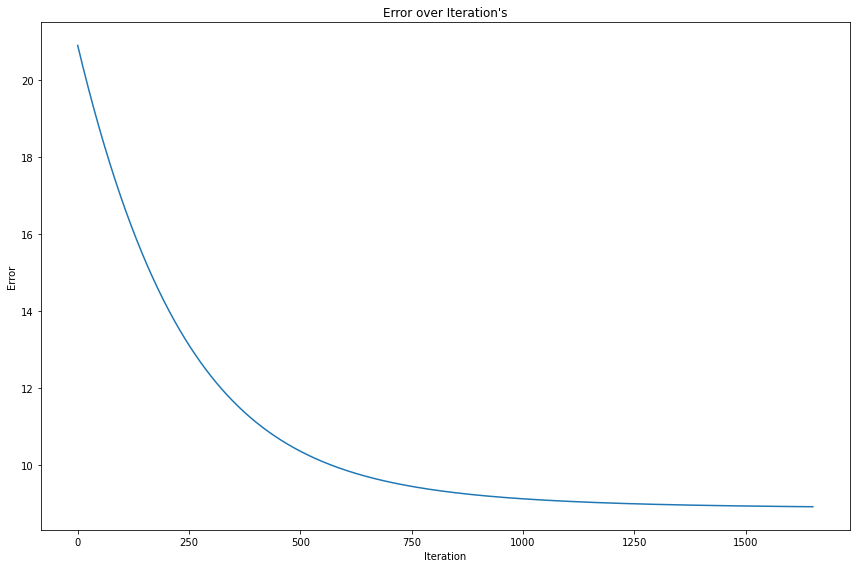

In [191]:
l5 = LinearRegression(train_X, train_Y, 0.01 * 1e-2, 0.01, "sgd", regularization = True, tolerance = 0.01 * 1e-2)
l5.fit()

In [192]:
l5.evaluation_metrics(mode ='train')

Training metrics
RMSE(training) --> 9.22002116074832
SSE(training) --> 19552.021747068764




In [193]:
l5.evaluation_metrics(mode ='test', X=test_X, y=test_Y)

Test metrics
RMSE(test) --> 10.308248337832103
SSE(test) --> 8182.01875217021




# Concrete dataset


In [194]:
concrete = pd.read_csv("/Users/praneithranganath/Downloads/concreteData.csv")
concrete.head()

,540,0,0.1,162,2.5,1040,676,28,79.99
0,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
1,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
3,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
4,266.0,114.0,0.0,228.0,0.0,932.0,670.0,90,47.03


In [195]:
d3 = DataPrep(concrete, '79.99', 0.25)

In [196]:
train_X, test_X, train_Y, test_Y, mean, std = d3.fit()

Closed Form

In [197]:
l10 = LinearRegression(train_X, train_Y, 0.1 * 1e-2, 0.01, "closed")
l10.fit()

[35.74150454 12.80299794  8.95932582  5.80101174 -3.31265169  1.37626128
  1.42344051  1.57479876  7.41973173]


Gradient Descent

  1%|▍                                     | 115/9999 [00:00<00:02, 3562.79it/s]

Model stopped learning
[35.74104097 12.1675386   8.35030401  5.25419515 -3.83621166  1.32511627
  0.95241266  0.97239434  7.39259636]


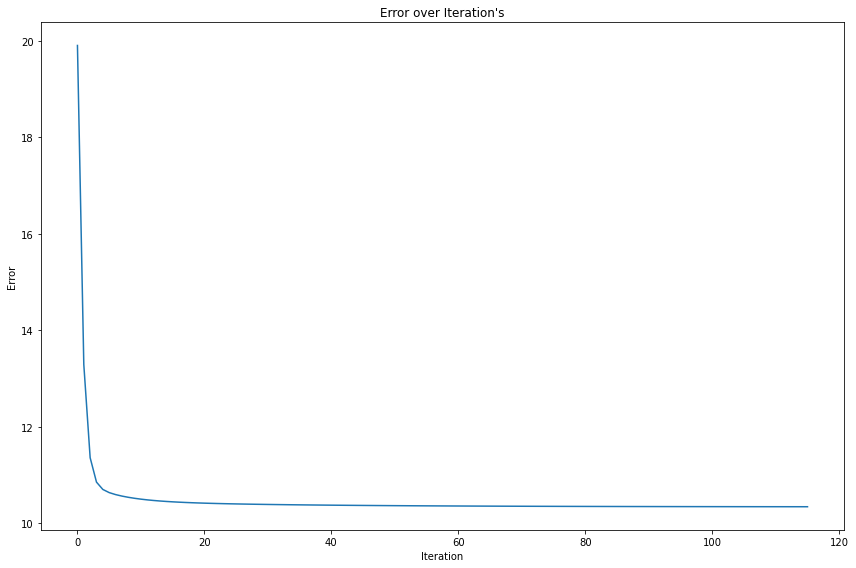

In [198]:
l8 = LinearRegression(train_X, train_Y, 0.7 * 1e-3, 0.01, "gd", regularization = True, tolerance = 0.1 * 1e-3)
l8.fit()

In [199]:
l8.evaluation_metrics(mode ='train')

Training metrics
RMSE(training) --> 10.343710456402741
SSE(training) --> 82491.09877054534




In [200]:
l8.evaluation_metrics(mode ='test', X=test_X, y=test_Y)

Test metrics
RMSE(test) --> 10.327593006215176
SSE(test) --> 27518.06774392235




Stochastic GD

  8%|███                                   | 790/9999 [00:00<00:01, 5197.13it/s]


Model stopped learning
[33.08288796 12.42984917  8.03749847  6.18323523 -0.98248772  2.65200617
  2.5343861   1.56576106  6.87093836]


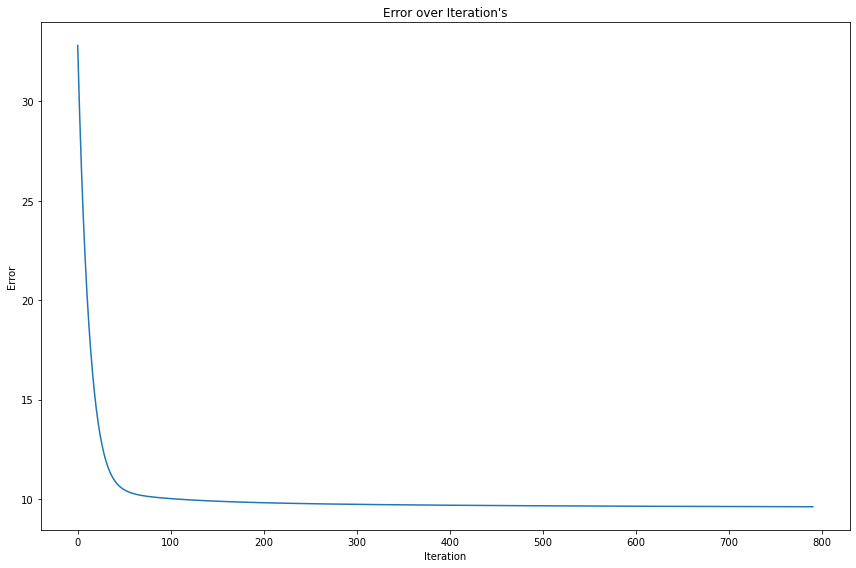

In [201]:
l9 = LinearRegression(train_X, train_Y, 0.7 * 1e-3, 0.01, "sgd", regularization = True, tolerance = 0.1 * 1e-3)
l9.fit()

In [202]:
l9.evaluation_metrics(mode ='train')

Training metrics
RMSE(training) --> 10.857503114577352
SSE(training) --> 90889.62326383687




In [203]:
l9.evaluation_metrics(mode ='test', X=test_X, y=test_Y)

Test metrics
RMSE(test) --> 11.114295325582136
SSE(test) --> 31870.11063073828


